# Libraries

In [591]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Databases

## Loading Providing Databases

In [592]:
urls = ['https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv',
        'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv',
        'https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv',
        'https://projects.fivethirtyeight.com/soccer-api/international/spi_global_rankings_intl.csv']

In [593]:
df_spi_matches = pd.read_csv(urls[1])
df_spi_matches_latest = pd.read_csv(urls[1])
df_spi_global_rankings = pd.read_csv(urls[2])
df_spi_global_rankings_intl = pd.read_csv(urls[3])

## Consolidated Databases

In [594]:
con = duckdb.connect()

In [595]:
query1 = """
    WITH data AS (
    SELECT * FROM df_spi_matches
    UNION
    SELECT * FROM df_spi_matches_latest)
    
    SELECT * FROM data"""

In [596]:
df_matches = con.execute(query1).fetchdf()
df_league_rankings = df_spi_global_rankings.copy()
df_conf_rankings = df_spi_global_rankings_intl.copy()

## Queries

### Exploratory Database

In [597]:
## Basic stats from League Database

query = """
    SELECT 
        DISTINCT(league) AS league, 
        COUNT(name) AS teams,
        ROUND(AVG(spi),2) AS average,
        ROUND(MEDIAN(spi),2) AS median,
        MAX(spi) AS max,
        MIN(spi) AS min
    FROM df_league_rankings
    GROUP BY 1
    ORDER BY 2 DESC"""

df_1 = con.execute(query).fetchdf()

In [598]:
## Summary from League Database

query = """
    WITH data AS (
        SELECT
            COUNT(league) leagues,
            SUM(teams) teams
        FROM df_1)
        
    SELECT
        leagues,
        teams, 
        teams/leagues avg_team_by_league,
        (SELECT MEDIAN(teams) FROM df_1) median,
        (SELECT MAX(teams) FROM df_1) max,
        (SELECT MIN(teams) FROM df_1) min
    FROM data"""

df_2_summary = con.execute(query).fetchdf()
df_2_summary = df_2_summary.T.reset_index()
df_2_summary.columns = ['Title','Number']
df_2_summary

,Title,Number
0,leagues,36.0
1,teams,643.0
2,avg_team_by_league,17.0
3,median,18.0
4,max,28.0
5,min,4.0


In [599]:
## Basic stats from Confederation Database

query = """
    SELECT 
        DISTINCT(confed) AS confederation, 
        COUNT(name) AS teams,
        ROUND(AVG(spi),2) AS average,
        ROUND(MEDIAN(spi),2) AS median,
        Max(spi) AS max,
        MIN(spi) AS min
    FROM df_conf_rankings
    GROUP BY 1
    ORDER BY 2 DESC"""

df_2 = con.execute(query).fetchdf()

In [600]:
## Summary from Confederation Database

query = """
    WITH data AS (
        SELECT
            COUNT(confederation) confederations,
            SUM(teams) teams
        FROM df_2)
        
    SELECT
        confederations,
        teams, 
        teams/confederations avg_team_by_confederation,
        (SELECT MEDIAN(teams) FROM df_2) median,
        (SELECT MAX(teams) FROM df_2) max,
        (SELECT MIN(teams) FROM df_2) min
    FROM data"""

df_2_summary = con.execute(query).fetchdf()
df_2_summary = df_2_summary.T.reset_index()
df_2_summary.columns = ['Title','Number']
df_2_summary

,Title,Number
0,confederations,6.0
1,teams,220.0
2,avg_team_by_confederation,36.0
3,median,44.0
4,max,56.0
5,min,10.0


### Teams Ranking

In [601]:
## League's Teams by Percentile

query = """
    WITH teams_by_league AS (
        SELECT
            DISTINCT(league) league,
            COUNT(league) AS teams
        FROM df_league_rankings
        GROUP BY 1
    ),

    ranking AS (    
        SELECT
            A.league,
            A.name,
            A.spi,
            A.off,
            A.def,
            ROW_NUMBER() OVER(PARTITION BY A.league ORDER BY A.spi) ReverseOrderByLeague,
            B.teams
        FROM df_league_rankings AS A
        LEFT JOIN teams_by_league AS B ON B.league = A.league)

    SELECT 
        *,
        ROUND((ReverseOrderByLeague*1.0)/teams,3) AS Percentile
    FROM ranking"""

df_league_percentile = con.execute(query).fetchdf()

In [602]:
## League's Top 80th Percentile

query = """
    SELECT 
        *
    FROM df_league_percentile
    WHERE Percentile >= 0.8"""

df_league_top = con.execute(query).fetchdf()

In [603]:
## League's Top 80th Percentile Summery

query = """
    SELECT 
        DISTINCT(league),
        COUNT(league) AS Top_Performers
    FROM df_league_top
    GROUP BY 1
    ORDER BY 2 DESC"""

df_league_top_summery = con.execute(query).fetchdf()

In [604]:
## League's Lowest 20th Percentile

query = """
    SELECT 
        *
    FROM df_league_percentile
    WHERE Percentile <= 0.2"""

df_league_lowest = con.execute(query).fetchdf()

In [605]:
## League's Lowest 20th Percentile Summery

query = """
    SELECT 
        DISTINCT(league),
        COUNT(league) AS Lowest_Performers
    FROM df_league_lowest
    GROUP BY 1
    ORDER BY 2 DESC"""

df_league_lowest_summery = con.execute(query).fetchdf()

In [606]:
## Confederations' Teams by Percentile

query = """
    WITH teams_by_confedereation AS (
        SELECT
            DISTINCT(confed) confedereation,
            COUNT(confed) AS teams
        FROM df_conf_rankings
        GROUP BY 1
    ),

    ranking AS (    
        SELECT
            A.confed,
            A.name,
            A.spi,
            A.off,
            A.def,
            ROW_NUMBER() OVER(PARTITION BY A.confed ORDER BY A.spi) ReverseOrderByConfed,
            B.teams
        FROM df_conf_rankings AS A
        LEFT JOIN teams_by_confedereation AS B ON B.confedereation = A.confed)
        
    SELECT 
        *,
        ROUND((ReverseOrderByConfed*1.0)/teams,3) AS Percentile
    FROM ranking"""

df_confed_percentile = con.execute(query).fetchdf()

In [607]:
## Confederations' Top 80th Percentile

query = """
    SELECT 
        *
    FROM df_confed_percentile
    WHERE Percentile >= 0.8"""

df_confed_top = con.execute(query).fetchdf()

In [608]:
## Confederations' Top 80th Percentile Summery

query = """
    SELECT 
        DISTINCT(confed),
        COUNT(confed) AS Top_Performers
    FROM df_confed_top
    GROUP BY 1
    ORDER BY 2 DESC"""

df_confed_top_summery = con.execute(query).fetchdf()

In [609]:
## Confederations' Lowest 20th Percentile

query = """
    SELECT 
        *
    FROM df_confed_percentile
    WHERE Percentile <= 0.2"""

df_confed_lowest = con.execute(query).fetchdf()

In [610]:
## Confederations' Lowest 20th Percentile Summery

query = """
    SELECT 
        DISTINCT(confed),
        COUNT(confed) AS Lowest_Performers
    FROM df_confed_lowest
    GROUP BY 1
    ORDER BY 2 DESC"""

df_confed_lowest_summery = con.execute(query).fetchdf()

### 

In [611]:
query = """
    WITH lowest AS (
    SELECT 
        DISTINCT(league),
        ROUND(AVG(spi),1) avg_lowest
    FROM df_league_lowest
    GROUP BY 1
    ORDER BY 2 DESC),

    top AS (
    SELECT 
        DISTINCT(league),
        ROUND(AVG(spi),1) avg_top
    FROM df_league_top
    GROUP BY 1
    ORDER BY 2 DESC),

    data AS (
        SELECT 
            top.*,
            lowest.avg_lowest
        FROM top
        LEFT JOIN lowest ON lowest.league = top.league)
        
    SELECT 
        *,
        ROUND(avg_top/avg_lowest,1) times_top_over_lowest
    FROM data
    ORDER BY 4 DESC"""

df_league_2 = con.execute(query).fetchdf()
df_league_2.dropna(axis=0, inplace= True)

In [612]:
query = """
    WITH lowest AS (
    SELECT 
        DISTINCT(confed),
        ROUND(AVG(spi),1) avg_lowest
    FROM df_confed_lowest
    GROUP BY 1
    ORDER BY 2 DESC),

    top AS (
    SELECT 
        DISTINCT(confed),
        ROUND(AVG(spi),1) avg_top
    FROM df_confed_top
    GROUP BY 1
    ORDER BY 2 DESC),

    data AS (
        SELECT 
            top.*,
            lowest.avg_lowest
        FROM top
        LEFT JOIN lowest ON lowest.confed = top.confed)
        
    SELECT 
        *,
        ROUND(avg_top/avg_lowest,1) times_top_over_lowest
    FROM data
    ORDER BY 4 DESC"""

df_confed_2 = con.execute(query).fetchdf()

In [613]:
## Query worst league with the worst teams from the best league

query = """
    WITH worst_league AS (
        SELECT 
            *
        FROM df_1
        WHERE median = (SELECT MIN(median)FROM df_1)
    ),

    best_league AS (
        SELECT 
            *
        FROM df_1
        WHERE median = (SELECT MAX(median)FROM df_1)
    )

    SELECT
        league,
        name,
        off,
        def,
        spi
    FROM df_league_lowest
    WHERE league = (SELECT league FROM best_league)
    
    UNION 
    
    SELECT
        league,
        name,
        off,
        def,
        spi
    FROM df_league_rankings
    WHERE league = (SELECT league FROM worst_league)"""

df_worst_league= con.execute(query).fetchdf()

In [614]:
## Query worst confederation with the worst teams from the best confederation

query = """
    WITH worst_confed AS (
        SELECT 
            *
        FROM df_2
        WHERE median = (SELECT MIN(median) FROM df_2)
    ),

    best_confed AS (
        SELECT 
            *
        FROM df_2
        WHERE median = (SELECT MAX(median) FROM df_2)
    )

    SELECT
        confed,
        name,
        off,
        def,
        spi
    FROM df_confed_lowest
    WHERE confed = (SELECT confederation FROM best_confed)
    
    UNION 
    
    SELECT
        confed,
        name,
        off,
        def,
        spi
    FROM df_conf_rankings
    WHERE confed = (SELECT confederation FROM worst_confed)"""

df_worst_confed = con.execute(query).fetchdf()

In [615]:
## Query best league with the best teams from the worst league

query = """
    WITH worst_league AS (
        SELECT 
            *
        FROM df_1
        WHERE median = (SELECT MIN(median)FROM df_1)
    ),

    best_league AS (
        SELECT 
            *
        FROM df_1
        WHERE median = (SELECT MAX(median)FROM df_1)
    )

    SELECT
        league,
        name,
        off,
        def,
        spi
    FROM df_league_rankings
    WHERE league = (SELECT league FROM best_league)
    
    UNION 
    
    SELECT
        league,
        name,
        off,
        def,
        spi
    FROM df_league_top
    WHERE league = (SELECT league FROM worst_league)"""

df_best_league = con.execute(query).fetchdf()

In [616]:
## Query best confederation with the best teams from the worst confederation

query = """
    WITH worst_confed AS (
        SELECT 
            *
        FROM df_2
        WHERE median = (SELECT MIN(median) FROM df_2)
    ),

    best_confed AS (
        SELECT 
            *
        FROM df_2
        WHERE median = (SELECT MAX(median) FROM df_2)
    )

    SELECT
        confed,
        name,
        off,
        def,
        spi
    FROM df_conf_rankings 
    WHERE confed = (SELECT confederation FROM best_confed)

    UNION 
    
    SELECT
        confed,
        name,
        off,
        def,
        spi
    FROM df_confed_top
    WHERE confed = (SELECT confederation FROM worst_confed)
    
"""

df_best_confed = con.execute(query).fetchdf()

# Football Data

<ul>
 <li>ESPN's SPI rating is the statistic used to classify the overall performance of each team.</li>
 <li>SPI rating is a statistic that aims to represent a team´s overall skill level based on its competitiveness ratings, match-based ratings and player-based ratings.</li>
 <li>SPI rating is forward looking rating, it shows the likelihood of victory if a competitive match were to be held the next day.</li>
 <li>League Dataset composed of <b>643</b> teams divided in <b>36</b> leagues for an average of <b>17</b> teams by league.</li>
 <li>Confederation Dataset composed of <b>220</b> teams divided in <b>6</b> confederations for an average of <b>36</b> teams by confederation.</li>
</ul>

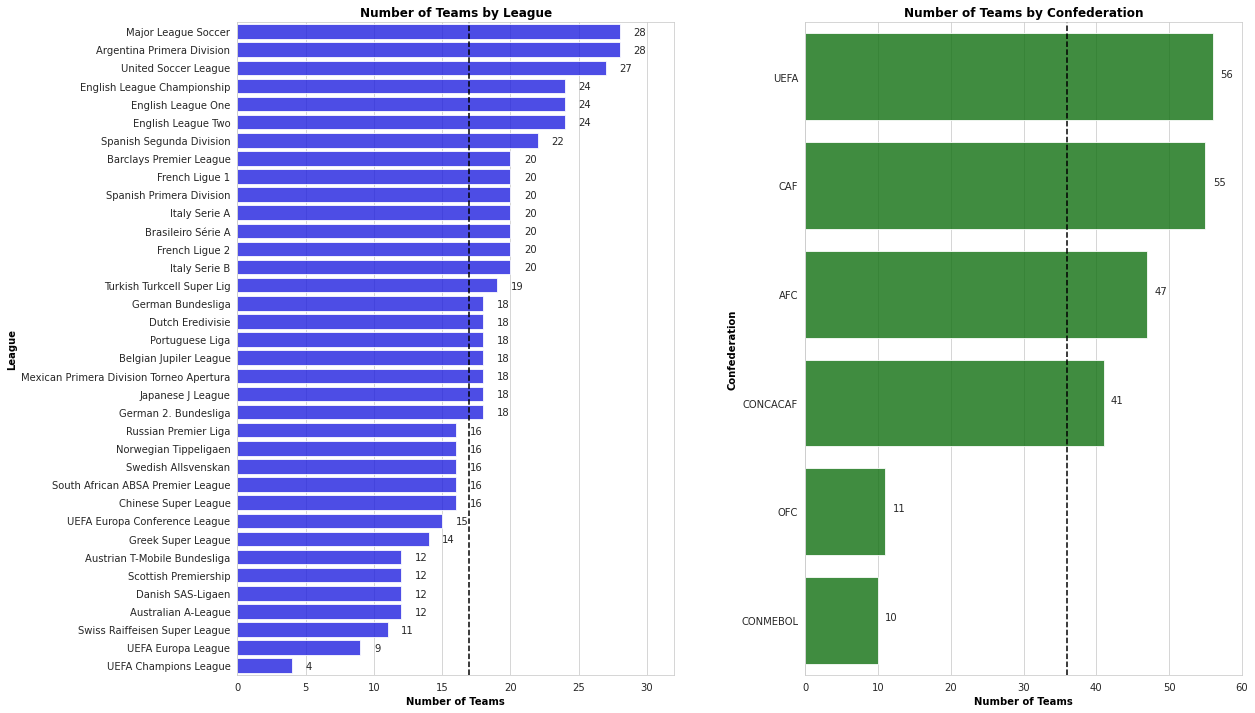

In [617]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(18, 12))

sns.barplot(x="teams", y="league", data=df_1, color="blue", alpha = 0.8, ax = ax[0])

ax[0].set(xlim=(0, 32), ylabel = "League", xlabel = "Number of Teams", title = "Number of Teams by League")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[0].axvline(17, color="k", linestyle= "--")

pos = range(df_1.shape[0])

for i, tick in zip(pos,ax[0].get_yticklabels()):
    ax[0].text(df_1['teams'].values[i] + 1, pos[i] + 0.2, df_1['teams'].values[i])

sns.barplot(x="teams", y="confederation", data=df_2, color="green", alpha = 0.8, ax = ax[1])

ax[1].set(xlim=(0, 60), ylabel = "Confederation", xlabel = "Number of Teams", title = "Number of Teams by Confederation")
ax[1].set_xlabel(ax[1].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_ylabel(ax[1].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[1].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[1].axvline(36, color="k", linestyle= "--")

pos = range(df_2.shape[0])

for i, tick in zip(pos,ax[1].get_yticklabels()):
    ax[1].text(df_2['teams'].values[i] + 1, pos[i], df_2['teams'].values[i])

plt.subplots_adjust(wspace=0.3)

## SPI Average by League/Confederation

<ul>
 <li>Median SPI for League/Confederation is an estimate of how good a League/Confederation is.</li>
 <li><i>The Top Leagues/Confederations</i> that are obtained are among the most populars Leagues/Confederations of the world which suggests that is a good estimate.</li>
</ul>

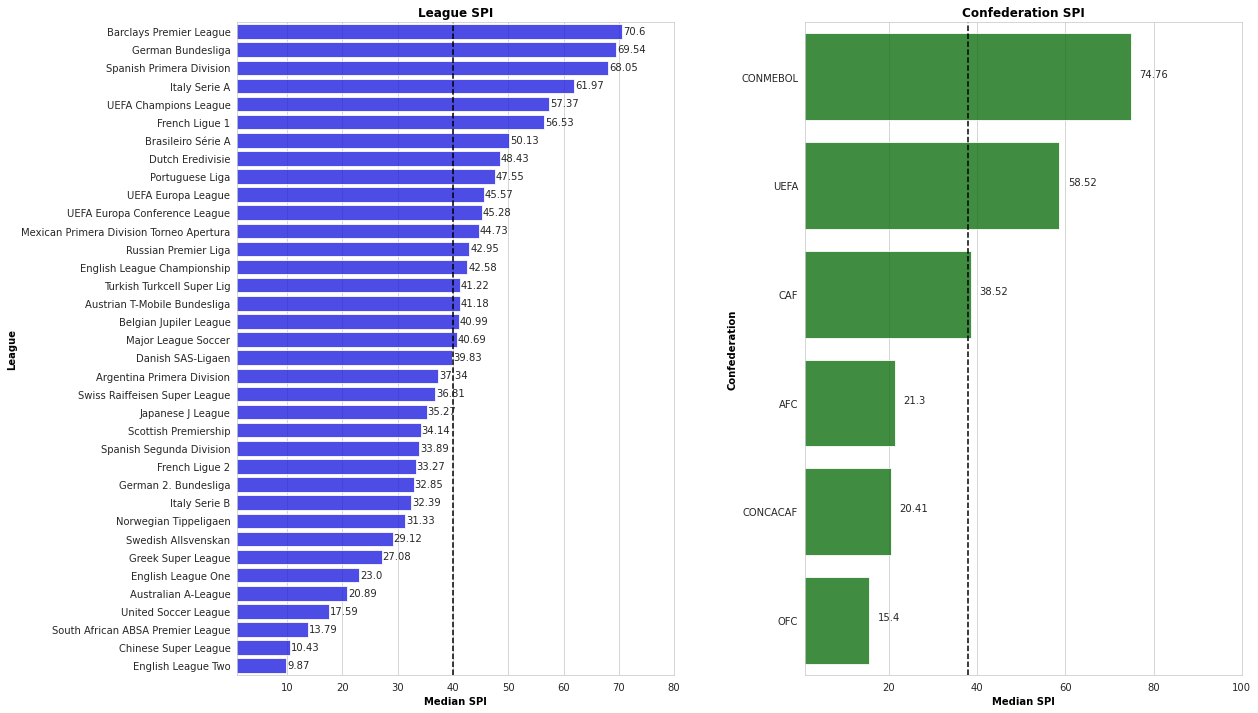

In [618]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(18, 12))

df_1.sort_values(by = ["median"], ascending= False, inplace = True)
sns.barplot(x= "median", y= "league", data=df_1, color="blue", alpha = 0.8, ax = ax[0])

ax[0].set(xlim=(1, 80), ylabel = "League", xlabel = "Median SPI", title = "League SPI")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[0].axvline(40, color="k", linestyle= "--")

pos = range(df_1.shape[0])

for i, tick in zip(pos,ax[0].get_yticklabels()):
    ax[0].text(df_1["median"].values[i] + 0.15, pos[i] + 0.15, df_1["median"].values[i])

df_2.sort_values(by = ["median"], ascending= False, inplace = True)
sns.barplot(x= "median", y="confederation", data=df_2, color="green", alpha = 0.8, ax = ax[1])

ax[1].set(xlim=(1, 100), ylabel = "Confederation", xlabel = "Median SPI", title = "Confederation SPI")
ax[1].set_xlabel(ax[1].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_ylabel(ax[1].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[1].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[1].axvline(38, color="k", linestyle= "--")

pos = range(df_2.shape[0])

for i, tick in zip(pos,ax[1].get_yticklabels()):
    ax[1].text(df_2["median"].values[i] + 2, pos[i] , df_2["median"].values[i])

plt.subplots_adjust(wspace=0.3)

## Who are the best and worst performing teams in each league?

<ul>
<li>Number of <i>Best</i> and <i>Worst</i> performing teams in each League/Confederation depending on the number of teams in each of them.</li>
<li><i>Top Performers</i> and <i>Low Performers</i> chose by percentiles. The former were chosen if the team was among the top <b>80th percentile</b> of each League/Confederation, the latter if they were among the lowest <b>20th percentile.</b></li>
</ul>

### <ul><li><b><i>Top Performimg</i> teams in each League:</b></li></ul>

In [619]:
pd.options.display.max_colwidth = 200
pd.merge(df_league_top_summery,df_league_top.sort_values(by = ['league','spi'], ascending= [True,False]).groupby(['league']).agg({'name': lambda x:  ", ".join(x)}).reset_index(),on = 'league')

,league,Top_Performers,name
0,Argentina Primera Division,6,"River Plate, Boca Juniors, Huracán, Velez Sarsfield, Racing Club, Talleres de Córdoba"
1,Major League Soccer,6,"Philadelphia Union, Los Angeles FC, New York City FC, Montreal Impact, Atlanta United FC, Nashville SC"
2,United Soccer League,6,"Louisville City FC, Tampa Bay Rowdies, San Diego Loyal SC, Birmingham Legion FC, San Antonio FC, Sacramento Republic FC"
3,Barclays Premier League,5,"Manchester City, Liverpool, Tottenham Hotspur, Arsenal, Chelsea"
4,Brasileiro Série A,5,"Flamengo, Palmeiras, Atletico Mineiro, Internacional, São Paulo"
5,English League Championship,5,"Norwich City, Sheffield United, West Bromwich Albion, Burnley, Watford"
6,English League One,5,"Sheffield Wednesday, Ipswich Town, Derby County, Barnsley, Portsmouth"
7,English League Two,5,"Salford City, Mansfield Town, Northampton Town, Leyton Orient, Swindon Town"
8,French Ligue 1,5,"Paris Saint-Germain, Lyon, Stade Rennes, Marseille, AS Monaco"
9,French Ligue 2,5,"St Etienne, Bordeaux, Sochaux, Metz, Guingamp"


### <ul><li><b><i>Least Performimg</i> teams in each League:</b></li></ul>

In [620]:
pd.options.display.max_colwidth = 200
pd.merge(df_league_lowest_summery,df_league_lowest.sort_values(by = ['league','spi'], ascending= [True,False]).groupby(['league']).agg({'name': lambda x:  ", ".join(x)}).reset_index(),on = 'league')

,league,Lowest_Performers,name
0,Argentina Primera Division,5,"Barracas Central, Patronato, Atlético Tucumán, Sarmiento, Aldosivi"
1,Major League Soccer,5,"Charlotte FC, Vancouver Whitecaps, San Jose Earthquakes, Houston Dynamo, DC United"
2,United Soccer League,5,"Indy Eleven, Las Vegas Lights FC, Loudoun United FC, Atlanta United 2, New York Red Bulls II"
3,Barclays Premier League,4,"Southampton, Fulham, AFC Bournemouth, Nottingham Forest"
4,Brasileiro Série A,4,"Atlético Goianiense, Coritiba, Avaí, Juventude"
5,English League Championship,4,"Wigan, Rotherham United, Reading, Hull City"
6,English League One,4,"Bristol Rovers, Burton Albion, Forest Green Rovers, Morecambe"
7,English League Two,4,"Carlisle United, Rochdale, Harrogate Town, Hartlepool"
8,French Ligue 1,4,"Brest, AC Ajaccio, Clermont Foot, Auxerre"
9,French Ligue 2,4,"Rodez, Annecy, Niort, US Quevilly"


### <ul><li><b><i>Top Performimg</i> teams in each Confederation:</b></li></ul>

In [621]:
pd.options.display.max_colwidth = 200
pd.merge(df_confed_top_summery,df_confed_top.sort_values(by = ['confed','spi'], ascending= [True,False]).groupby(['confed']).agg({'name': lambda x:  ", ".join(x)}).reset_index(),on = 'confed')

,confed,Top_Performers,name
0,CAF,12,"Morocco, Algeria, Tunisia, Mali, Senegal, Ivory Coast, Cameroon, Nigeria, Egypt, Ghana, Burkina Faso, Gabon"
1,UEFA,12,"Spain, Germany, Portugal, France, Netherlands, England, Belgium, Denmark, Italy, Croatia, Switzerland, Serbia"
2,AFC,10,"Japan, South Korea, Iran, Australia, Saudi Arabia, Qatar, Bahrain, Uzbekistan, Oman, United Arab Emirates"
3,CONCACAF,9,"Mexico, USA, Canada, Panama, Guatemala, Costa Rica, Haiti, Jamaica, Honduras"
4,CONMEBOL,3,"Brazil, Argentina, Uruguay"
5,OFC,3,"New Zealand, Fiji, Solomon Islands"


### <ul><li><b><i>Least Performimg</i> teams in each Confederation:</b></li></ul>

In [622]:
pd.options.display.max_colwidth = 200
pd.merge(df_confed_lowest_summery,df_confed_lowest.sort_values(by = ['confed','spi'], ascending= [True,False]).groupby(['confed']).agg({'name': lambda x:  ", ".join(x)}).reset_index(),on = 'confed')

,confed,Lowest_Performers,name
0,CAF,11,"Liberia, Chad, Lesotho, Zanzibar, South Sudan, Eritrea, Sao Tome and Principe, Mauritius, Somalia, Djibouti, Seychelles"
1,UEFA,11,"Azerbaijan, Kazakhstan, Faroe Islands, Moldova, Cyprus, Lithuania, Malta, Andorra, Gibraltar, Liechtenstein, San Marino"
2,AFC,9,"Guam, Northern Mariana Islands, Sri Lanka, Brunei, Pakistan, Laos, Bhutan, Timor-Leste, Macau"
3,CONCACAF,8,"Bonaire, Cayman Islands, St. Martin, Anguilla, US Virgin Islands, British Virgin Islands, Sint Maarten, Turks and Caicos Islands"
4,CONMEBOL,2,"Paraguay, Bolivia"
5,OFC,2,"Samoa, Tonga"


## How much better are the best performers than the worst performers in each league?

<ul>
    <li>Taking <i>Top Performers</i> and <i>Low Performers</i> teams by League, it is possible to identify a negative relationship beteween <i>Offensive Ratings</i> and <i>Defensive Ratings,</i> suggesting that if a team has high score in <i>Offensive Rating</i> it will have a low score in <i>Defensive Rating.</i></li>
    <li>Correlation beteween <i>Offensive Rating</i> and <i>Defensive Rating</i> is approximately <b><i>-0.85</i></b> implying high negative correlation. Morever, when segmenting between <i>Top Performers</i> and <i>Low Performers</i> teams, it is found that <i>Top Performers teams</i> are among the teams whith higher <i>Offensive Ratings</i> and thereby, with high <i>SPI</i> score.</li>
    <li>Same pattern is observed in Confederations' <i>Top Performers</i> and <i>Low Performers</i>.</li>
</ul>

/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


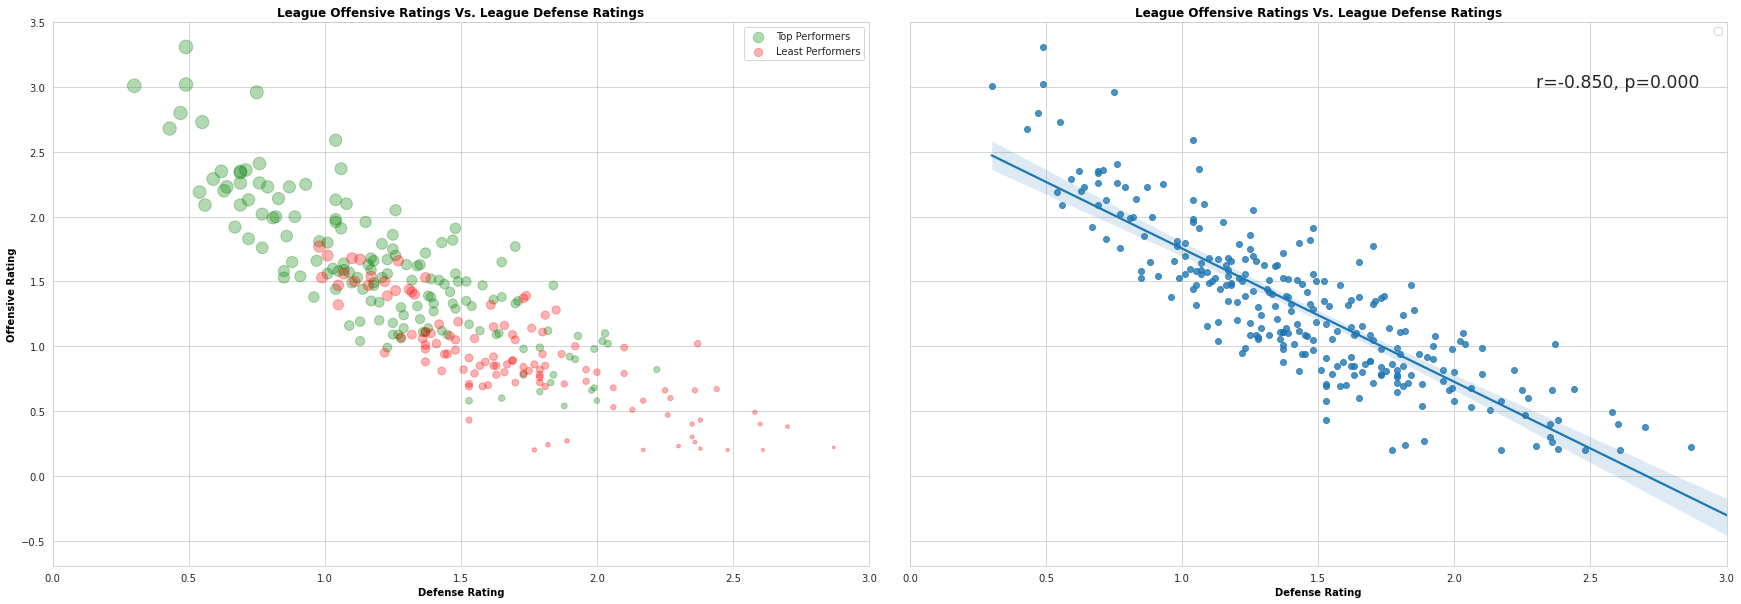

In [623]:
fig ,ax = plt.subplots(1,2,figsize=(30, 10), sharey=True)

ax[0].scatter(x = df_league_top["def"], y = df_league_top["off"], s= 2*df_league_top["spi"], alpha=0.3, color = "green", label = "Top Performers")
ax[0].scatter(x = df_league_lowest["def"], y = df_league_lowest["off"], s= 2*df_league_lowest["spi"], alpha=0.3,  color = "red", label = "Least Performers")
ax[0].set(xlim=(0, 3), ylabel = "Offensive Rating", xlabel = "Defense Rating", title = "League Offensive Ratings Vs. League Defense Ratings")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].legend()

import scipy.stats as stats

df = pd.concat([df_league_top,df_league_lowest]).reset_index(drop = True)
r, p = stats.pearsonr(df["def"],df["off"])

g = sns.regplot("def", "off", data = df, ax = ax[1])
ax[1].set(xlim=(0, 3), xlabel = "Defense Rating", ylabel = "", title = "League Offensive Ratings Vs. League Defense Ratings")
ax[1].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].text(2.3, 3, 'r={:0.3f}, p={:0.3f}'.format(r,p), fontsize = 'xx-large')
ax[1].legend()

plt.subplots_adjust(wspace=0.05)
plt.show()

/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


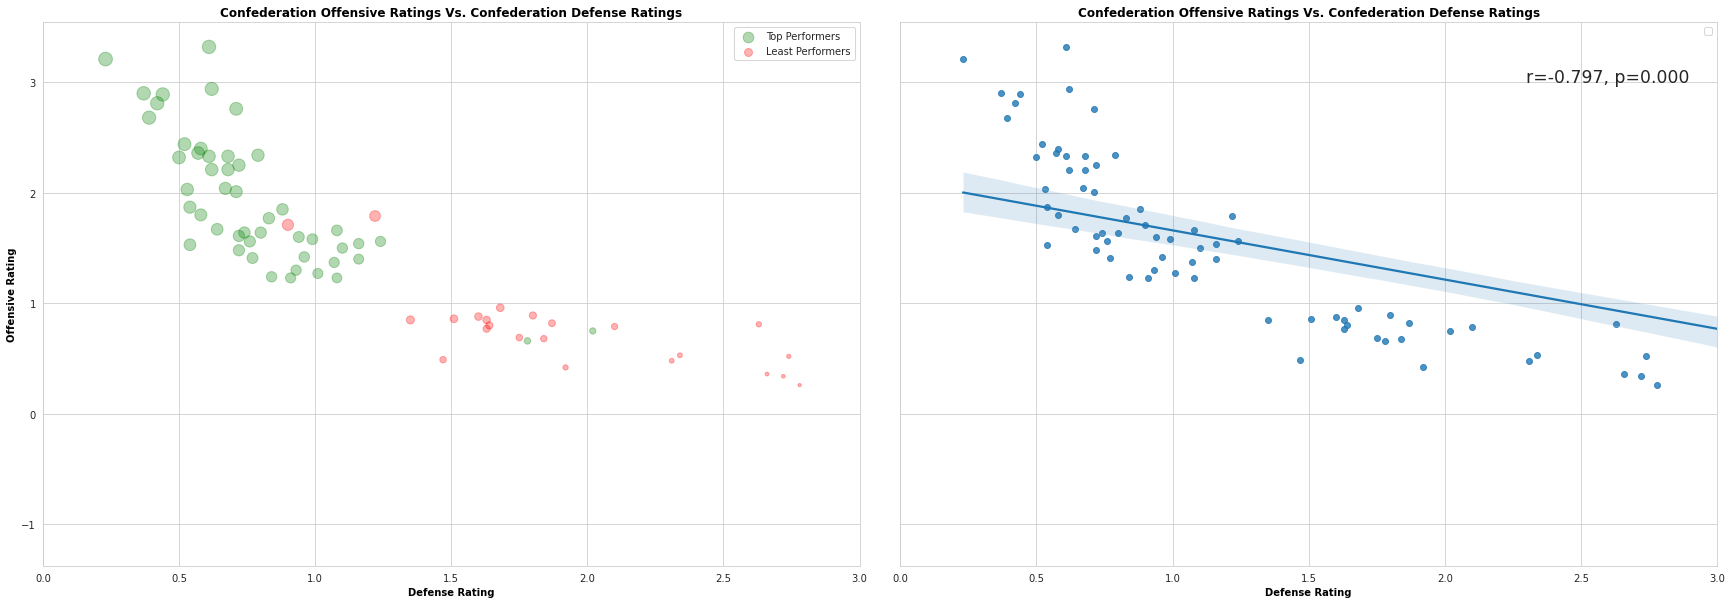

In [624]:
fig ,ax = plt.subplots(1,2,figsize=(30, 10), sharey=True)

ax[0].scatter(x = df_confed_top["def"], y = df_confed_top["off"], s= 2*df_confed_top["spi"], alpha=0.3, color = "green", label = "Top Performers")
ax[0].scatter(x = df_confed_lowest["def"], y = df_confed_lowest["off"], s= 2*df_confed_lowest["spi"], alpha=0.3,  color = "red", label = "Least Performers")
ax[0].set(xlim=(0, 3), ylabel = "Offensive Rating", xlabel = "Defense Rating", title = "Confederation Offensive Ratings Vs. Confederation Defense Ratings")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].legend()

import scipy.stats as stats

df = pd.concat([df_confed_top,df_confed_lowest]).reset_index(drop = True)
r, p = stats.pearsonr(df["def"],df["off"])

g = sns.regplot("def", "off", data = df, ax = ax[1])
ax[1].set(xlim=(0, 3), xlabel = "Defense Rating", ylabel = "", title = "Confederation Offensive Ratings Vs. Confederation Defense Ratings")
ax[1].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].text(2.3, 3, 'r={:0.3f}, p={:0.3f}'.format(r,p), fontsize = 'xx-large')
ax[1].legend()

plt.subplots_adjust(wspace=0.05)
plt.show()

<ul>
    <li>In order to identify how much better <i>The Best Performers</i> are than <i>The Worst Performers</i> in each league, the <i>Average SPI</i> is calculated among the <i>Top Performers</i> and <i>Low Performers</i> in each league, this gives as a result the <i>Average Performance</i> in terms of the SPI score.</li>
    <li>The <i>Average SPI for The Best Performers</i> is divided by <i>Average SPI for The Worst Performers,</i> thus an estimator is obtained, which provides information of how many times The Best Performers are away from the The Worst Performers.</li>
    <li>If the estimator is <i>equal to 1</i> it means there is not much difference between <i>Top Performers</i> and <i>Low Performers</i> teams. If the estimator is <i>greater than 1</i> it suggests the number of times <i>Top Performers</i> are away from <i>Low Performers</i> teams in terms of <i>SPI score</i>, i.e., if the estimator is 2, it implies that the <i>Top Performers</i> are twice better than <i>Low Performers.</i></li>
</ul>

<ul>
    <li>On average on leagues, in terms of SPI score, <i>The Best Performers</i> teams are away from <i>The Worst Performers</i> twice.</li>
    <li>On average on cofederetaions, in terms of SPI score, <i>The Best Performers</i> teams are away from <i>The Worst Performers</i> 15 times.</li>
</ul>

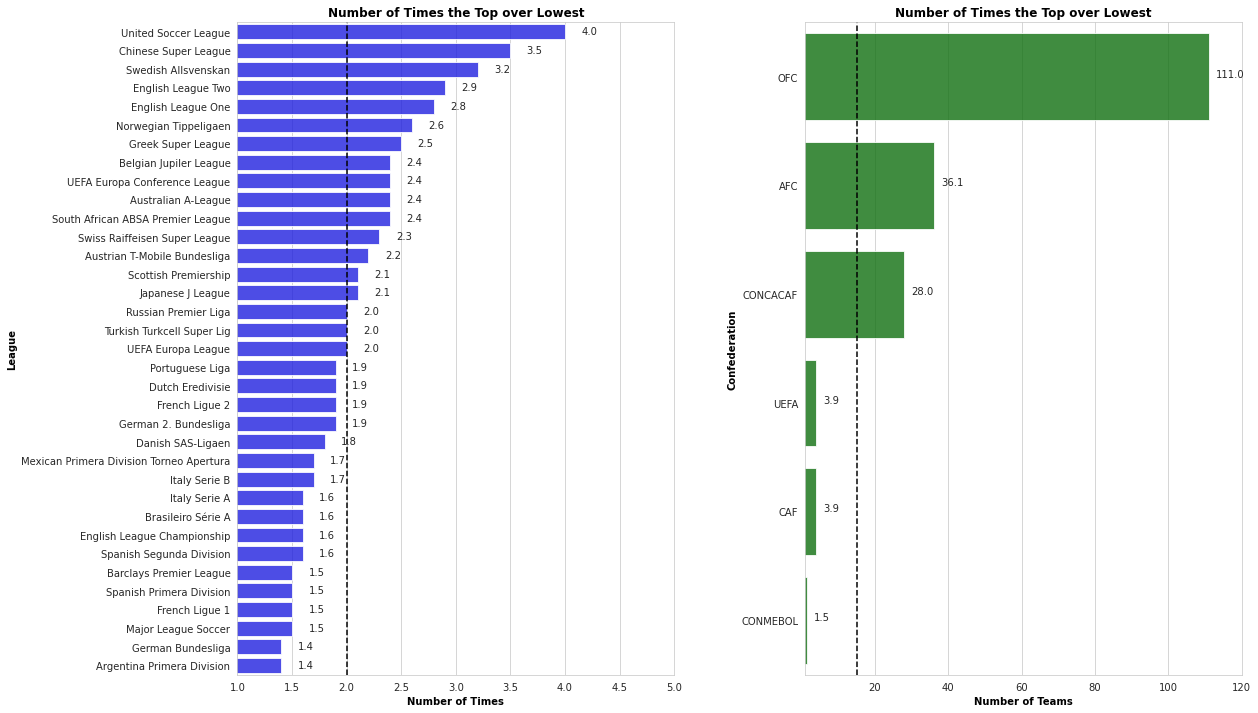

In [625]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize=(18, 12))

sns.barplot(x="times_top_over_lowest", y="league", data=df_league_2, color="blue", alpha = 0.8, ax = ax[0])

ax[0].set(xlim=(1, 5), ylabel = "League", xlabel = "Number of Times", title = "Number of Times the Top over Lowest")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[0].axvline(2, color="k", linestyle= "--")

pos = range(df_league_2.shape[0])

for i, tick in zip(pos,ax[0].get_yticklabels()):
    ax[0].text(df_league_2['times_top_over_lowest'].values[i] + 0.15, pos[i] + 0.15, df_league_2['times_top_over_lowest'].values[i])

sns.barplot(x="times_top_over_lowest", y="confed", data=df_confed_2, color="green", alpha = 0.8, ax = ax[1])

ax[1].set(xlim=(1, 120), ylabel = "Confederation", xlabel = "Number of Teams", title = "Number of Times the Top over Lowest")
ax[1].set_xlabel(ax[1].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_ylabel(ax[1].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[1].get_title(), fontdict={'weight': 'bold', 'color':'black'})

ax[1].axvline(15, color="k", linestyle= "--")

pos = range(df_2.shape[0])

for i, tick in zip(pos,ax[1].get_yticklabels()):
    ax[1].text(df_confed_2['times_top_over_lowest'].values[i] + 2, pos[i] , df_confed_2['times_top_over_lowest'].values[i])

plt.subplots_adjust(wspace=0.3)

<ul>
    <li>On leagues, <i>49%</i> of leagues are between <i>1.4</i> and <i>1.9</i> which implies that the leagues are highly competitive, due to <i>The Best Performers</i> teams are not much different from <i>The Worst Performers,</i> in terms SPI score, which represents the teams' overall skill level, this means that <i>The Best Performers</i> have more or less the same skills than <i>The Worst Performers.</i></li>
    <li>On leagues, <i>31%</i> of leagues are between <i>2</i> and <i>2.4</i> which implies that <i>The Best Performers</i> teams are indeed different from <i>The Worst Performers,</i> in terms SPI score, its higher average mean is capturing this difference.</i></li>
    <li>On confederations, <i>3</i> of them have relatively low score, between <i>1.5</i> and <i>3.9</i> which implies are the most competitive confederations. This result is backed by the Averege SPI calculated for each confederation an this ones are among the top 3 with higher results.</li>
    <li>It is astonishing the result gotten from OFC, which stands for Oceania Football Confederation. The score is as high as <i>111.</i> The result is obtained due to the gap in SPI score from <i>The Best Performers</i> teams and <i>The Worst Performers,</i> the former has a SPI score of <i>33.3</i> and the latter of <i>0.3,</i> thereby the result, this condefederation is <i>the worst</i> in terms of Average SPI by Confederation.</li>
</ul>

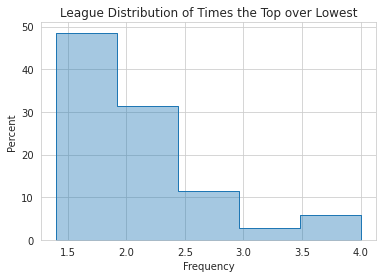

In [626]:
fig = sns.histplot(df_league_2["times_top_over_lowest"], stat = 'percent',alpha = 0.4,element="step",  bins = 5)
fig.set(ylabel = "Percent", xlabel = "Frequency", title = "League Distribution of Times the Top over Lowest")
plt.show()

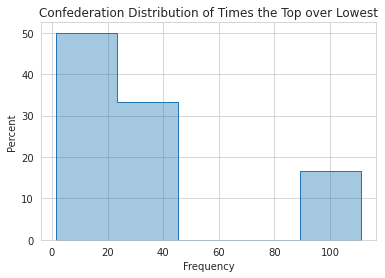

In [627]:
fig = sns.histplot(df_confed_2["times_top_over_lowest"], stat = 'percent',alpha = 0.4,element="step", bins = 5)
fig.set(ylabel = "Percent", xlabel = "Frequency", title = "Confederation Distribution of Times the Top over Lowest")
plt.show()

## How would the worst performers in the best league perform in the worst performing league?

<ul>
    <li>SPI Average by League/Confederation suggests that the best league and the best confederations are <i>Barclays Premier League</i> and <i>CONMEBOL,</i> respectively.</li>
    <li><i>The Worst Performers</i> in <i>Barclays Premier League</i> are Southampton, Fulham, AFC Bournemouth and Nottingham Forest, their <i>Average SPI score</i> is <b><i>58.6</i>.</b></li>
    <li><i>The Worst Performers</i> in <i>CONMEBOL</i> is Bolivia and Paraguay, their <i>Average SPI score</i> is <b><i>60.5</i>.</b></li>
</ul>

<ul>
    <li>SPI Average by League/Confederation suggests that the worst league and the worst confederations are <i>English League Two</i> and <i>OFC,</i> respectively.</li>
    <li><i>The Best Performers</i> in <i>English League Two</i> are Salford City, Mansfield Town, Northampton Town, Leyton Orient and Swindon Town, their <i>Average SPI score</i> is <b><i>18.1</i>.</b></li>
    <li><i>The Best Performers</i> in <i>OFC</i> are New Zealand, Fiji and Solomon Islands, their <i>Average SPI score</i> is <b><i>33.3</i>.</b></li>
</ul>

<ul>
    <li>SPI score suggests that <i>The Worst Performers</i> in <i>Barclays Premier League</i> and <i>CONMEBOL</i> will be <i>The Best Performers</i> in  <i>English League Two</i> and <i>OFC</i> if they were transfered.</li>
</ul>

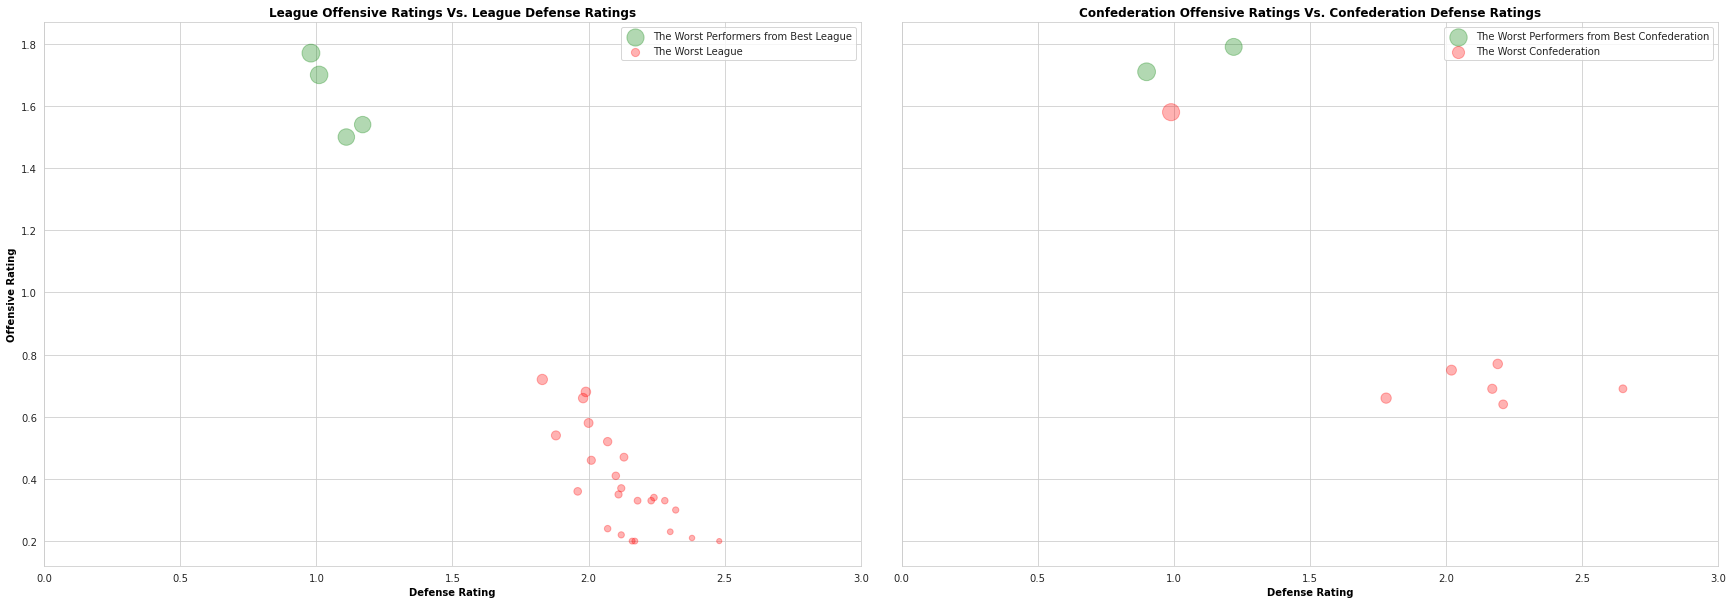

In [628]:
fig ,ax = plt.subplots(1,2,figsize=(30, 10), sharey=True)

df_1 = df_worst_league.loc[df_worst_league["league"] == "Barclays Premier League"]
df_2 = df_worst_league.loc[df_worst_league["league"] == "English League Two"]

ax[0].scatter(x = df_1["def"], y = df_1["off"], s= 5*df_1["spi"], alpha=0.3, color = "green", label = "The Worst Performers from Best League")
ax[0].scatter(x = df_2["def"], y = df_2["off"], s= 5*df_2["spi"], alpha=0.3,  color = "red", label = "The Worst League")
ax[0].set(xlim=(0, 3), ylabel = "Offensive Rating", xlabel = "Defense Rating", title = "League Offensive Ratings Vs. League Defense Ratings")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].legend()

df_1 = df_worst_confed.loc[df_worst_confed["confed"] == "CONMEBOL"]
df_2 = df_worst_confed.loc[df_worst_confed["confed"] == "OFC"]

ax[1].scatter(x = df_1["def"], y = df_1["off"], s= 5*df_1["spi"], alpha=0.3, color = "green", label = "The Worst Performers from Best Confederation")
ax[1].scatter(x = df_2["def"], y = df_2["off"], s= 5*df_2["spi"], alpha=0.3,  color = "red", label = "The Worst Confederation")
ax[1].set(xlim=(0, 3), ylabel = "", xlabel = "Defense Rating", title = "Confederation Offensive Ratings Vs. Confederation Defense Ratings")
ax[1].set_xlabel(ax[1].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[1].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].legend()

plt.subplots_adjust(wspace=0.05)
plt.show()

## How would the best performers in the worst league perform in the best performing league?

<ul>
    <li>SPI Average by League/Confederation suggests that the worst league and the worst confederations are <i>English League Two</i> and <i>OFC,</i> respectively.</li>
    <li><i>The Best Performers</i> in <i>English League Two</i> are Salford City, Mansfield Town, Northampton Town, Leyton Orient and Swindon Town, their <i>Average SPI score</i> is <b><i>18.1</i>.</b></li>
    <li><i>The Best Performers</i> in <i>OFC</i> are New Zealand, Fiji, Solomon Islands and Tahiti, their <i>Average SPI score</i> is <b><i>33.3</i>.</b></li>
</ul>

<ul>
    <li>SPI Average by League/Confederation suggests that the best league and the best confederations are <i>Barclays Premier League</i> and <i>CONMEBOL,</i> respectively.</li>
    <li><i>The Worst Performers</i> in <i>Barclays Premier League</i> are Fulham, AFC Bournemouth and Nottingham Forest, their <i>Average SPI score</i> is <b><i>58.6</i>.</b></li>
    <li><i>The Worst Performers</i> in <i>CONMEBOL</i> are Bolivia and Paraguay, its <i>Average SPI score</i> is <b><i>60.5</i>.</b></li>
</ul>

<ul>
    <li>SPI score suggests that <i>The Best Performers</i> in <i>English League Two</i> and <i>OFC</i> will be <i>The Worst Performers</i> in <i>Barclays Premier League</i> and <i>CONMEBOL</i> if they were transfered.</li>
</ul>

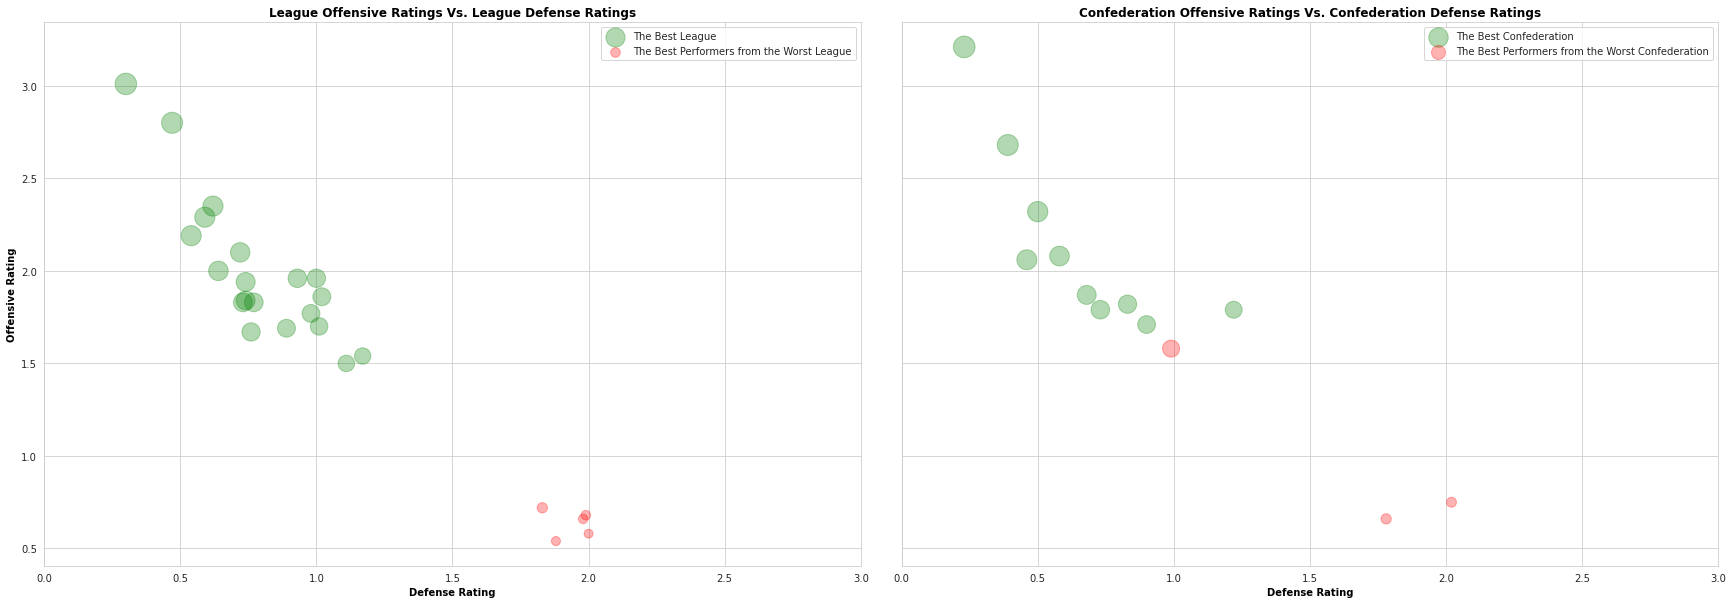

In [629]:
fig ,ax = plt.subplots(1,2,figsize=(30, 10), sharey=True)

df_1 = df_best_league.loc[df_best_league["league"] == "Barclays Premier League"]
df_2 = df_best_league.loc[df_best_league["league"] == "English League Two"]

ax[0].scatter(x = df_1["def"], y = df_1["off"], s= 5*df_1["spi"], alpha=0.3, color = "green", label = "The Best League")
ax[0].scatter(x = df_2["def"], y = df_2["off"], s= 5*df_2["spi"], alpha=0.3,  color = "red", label = "The Best Performers from the Worst League")
ax[0].set(xlim=(0, 3), ylabel = "Offensive Rating", xlabel = "Defense Rating", title = "League Offensive Ratings Vs. League Defense Ratings")
ax[0].set_xlabel(ax[0].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_ylabel(ax[0].get_ylabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].set_title(ax[0].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[0].legend()

df_1 = df_best_confed.loc[df_best_confed["confed"] == "CONMEBOL"]
df_2 = df_best_confed.loc[df_best_confed["confed"] == "OFC"]

ax[1].scatter(x = df_1["def"], y = df_1["off"], s= 5*df_1["spi"], alpha=0.3, color = "green", label = "The Best Confederation")
ax[1].scatter(x = df_2["def"], y = df_2["off"], s= 5*df_2["spi"], alpha=0.3,  color = "red", label = "The Best Performers from the Worst Confederation")
ax[1].set(xlim=(0, 3), ylabel = "", xlabel = "Defense Rating", title = "Confederation Offensive Ratings Vs. Confederation Defense Ratings")
ax[1].set_xlabel(ax[1].get_xlabel(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].set_title(ax[1].get_title(), fontdict={'weight': 'bold', 'color':'black'})
ax[1].legend()

plt.subplots_adjust(wspace=0.05)
plt.show()